# Run-to-Run Comparison

This notebook contrasts multiple LLM runs on the Känguru benchmark using the evaluation metrics produced in `evaluate_results.ipynb`. Configure the runs below to see consolidated tables, text highlights, and visualizations that emphasize where models differ or align.

## Select Runs

Provide the run directory names (timestamp + model identifier) you want to compare. Leave the list empty to automatically fall back to the latest few runs.

In [85]:
from pathlib import Path

# Provide the run IDs to compare. Examples: "20251013_191510_openai-gpt-5"
run_ids = [
    "20251013_191510_openai-gpt-5",
    "20251013_191528_x-ai-grok-4-fast",
    "20251014_080823_qwen-qwen3-vl-235b-a22b-thinking",
    "20251020_212534_anthropic-claude-sonnet-4.5"
]

# Directory containing run outputs
runs_dir = Path("runs")

# When run_ids is empty, fall back to this many most recent runs
fallback_latest_n = 2

In [86]:
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import score_utils

plt.style.use("seaborn-v0_8-darkgrid")


def resolve_run_ids(run_ids: List[str], runs_dir: Path, fallback_latest_n: int = 5) -> Tuple[List[str], List[str]]:
    runs_dir = Path(runs_dir)
    if not runs_dir.exists():
        raise ValueError(f"Runs directory not found: {runs_dir}")
    available = sorted([p.name for p in runs_dir.iterdir() if p.is_dir()])
    if run_ids:
        missing = [rid for rid in run_ids if rid not in available]
        if missing:
            raise ValueError(f"Run IDs not found under {runs_dir}: {missing}")
        selected = run_ids
    else:
        if not available:
            raise ValueError(f"No runs found under {runs_dir}")
        selected = available[-fallback_latest_n:]
    return selected, available


def _primary_grade(group_label: Any) -> int:
    numbers = score_utils.extract_grade_numbers(group_label)
    return min(numbers) if numbers else 0


def _grade_band(group_label: Any) -> str:
    g = _primary_grade(group_label)
    if g == 0:
        return "Unknown"
    if 3 <= g <= 6:
        return "Lower (3-6)"
    if 7 <= g <= 13:
        return "Upper (7-13)"
    return "Other"


def _grade_sort_key(label: Any) -> int:
    return _primary_grade(label)


def _model_label_from_run(run_id: str) -> str:
    parts = run_id.split("_", 2)
    return parts[2] if len(parts) >= 3 else run_id


def load_run_dataframe(run_id: str, runs_dir: Path) -> pd.DataFrame:
    results_path = Path(runs_dir) / run_id / "results.filled.parquet"
    if not results_path.exists():
        raise FileNotFoundError(f"results.filled.parquet not found for run {run_id}")
    df = pd.read_parquet(results_path).copy()

    df['predicted_normalized'] = (
        df['predicted'].fillna('').astype(str).str.strip().str.upper()
    )
    df['has_answer'] = df['predicted_normalized'] != ''
    df['declined'] = df['predicted_normalized'] == score_utils.DECLINED_TOKEN
    df['attempted'] = df['has_answer'] & (~df['declined'])
    df['answered_correctly'] = df['is_correct'].fillna(False).astype(bool)
    df['answered_incorrectly'] = df['attempted'] & (~df['answered_correctly'])
    df['question_points'] = pd.to_numeric(df['points'], errors='coerce').fillna(0.0)
    df['raw_points'] = np.where(df['answered_correctly'], df['question_points'], 0.0)
    df['max_points'] = df['question_points']
    df['awarded_points'] = np.where(
        df['answered_correctly'],
        df['question_points'],
        np.where(df['attempted'], -score_utils.PENALTY_FACTOR * df['question_points'], 0.0),
    )

    if 'multimodal' in df.columns:
        modality_bool = df['multimodal'].fillna(False).astype(bool)
    else:
        modality_bool = pd.Series(False, index=df.index)
    df['modality'] = np.where(modality_bool, 'Multimodal', 'Text-only')
    df['grade_band'] = df['group'].apply(_grade_band)

    if 'completion_tokens' in df.columns:
        df['completion_tokens'] = pd.to_numeric(df['completion_tokens'], errors='coerce')

    return df


def aggregate_exam_scores(df: pd.DataFrame) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for (year, group), g in df.groupby(['year', 'group'], dropna=False):
        start_points = score_utils.start_points_for_group(group)
        earned_points = g['raw_points'].sum()
        total_score = start_points + earned_points
        rows.append({
            'year': year,
            'exam': group,
            'start_points': start_points,
            'earned_points': earned_points,
            'total_score': total_score,
            'correct': int(g['answered_correctly'].sum()),
            'questions': len(g),
        })
    if not rows:
        return pd.DataFrame(columns=['year', 'exam', 'start_points', 'earned_points', 'total_score', 'correct', 'questions'])
    exam_df = pd.DataFrame(rows)
    exam_df = exam_df.sort_values(['year', 'exam']).reset_index(drop=True)
    return exam_df


def compute_slice_metrics(df: pd.DataFrame) -> Dict[str, Any]:
    total = len(df)
    if total == 0:
        return {
            'questions': 0,
            'correct': 0,
            'attempts': 0,
            'declines': 0,
            'recall': np.nan,
            'attempt_rate': np.nan,
            'decline_rate': np.nan,
            'precision': np.nan,
            'net_points_pct': np.nan,
        }
    correct = int(df['answered_correctly'].sum())
    attempts = int(df['attempted'].sum())
    declines = int(df['declined'].sum())
    precision = correct / attempts if attempts else np.nan
    recall = correct / total if total else np.nan
    attempt_rate = attempts / total if total else np.nan
    decline_rate = declines / total if total else np.nan
    max_points = df['max_points'].sum()
    net_points_pct = 100.0 * df['awarded_points'].sum() / max_points if max_points > 0 else np.nan
    return {
        'questions': total,
        'correct': correct,
        'attempts': attempts,
        'declines': declines,
        'recall': recall,
        'attempt_rate': attempt_rate,
        'decline_rate': decline_rate,
        'precision': precision,
        'net_points_pct': net_points_pct,
    }


def summarize_run(df: pd.DataFrame, run_id: str) -> Tuple[Dict[str, Any], pd.DataFrame]:
    slice_metrics = compute_slice_metrics(df)
    exam_scores = aggregate_exam_scores(df)
    total_tokens = np.nan
    if 'completion_tokens' in df.columns:
        total_tokens = float(df['completion_tokens'].sum(skipna=True))
        if not np.isfinite(total_tokens) or total_tokens <= 0:
            total_tokens = np.nan

    model_label = _model_label_from_run(run_id)
    summary: Dict[str, Any] = {
        'run_id': run_id,
        'model': model_label,
        'questions': slice_metrics['questions'],
        'correct': slice_metrics['correct'],
        'attempts': slice_metrics['attempts'],
        'declines': slice_metrics['declines'],
        'attempt_rate': slice_metrics['attempt_rate'],
        'decline_rate': slice_metrics['decline_rate'],
        'precision': slice_metrics['precision'],
        'recall': slice_metrics['recall'],
        'f1_like': (
            2 * slice_metrics['precision'] * slice_metrics['recall'] / (slice_metrics['precision'] + slice_metrics['recall'])
            if np.isfinite(slice_metrics['precision']) and np.isfinite(slice_metrics['recall']) and (slice_metrics['precision'] + slice_metrics['recall']) > 0
            else np.nan
        ),
        'net_points_pct': slice_metrics['net_points_pct'],
        'raw_points_total': df['raw_points'].sum(),
        'start_points_total': exam_scores['start_points'].sum() if not exam_scores.empty else 0.0,
        'total_exam_score': exam_scores['total_score'].sum() if not exam_scores.empty else df['raw_points'].sum(),
        'exam_count': len(exam_scores),
        'token_sum': total_tokens,
    }

    if np.isfinite(total_tokens):
        k = total_tokens / 1000.0 if total_tokens else np.nan
        summary['points_per_1k_tokens'] = summary['raw_points_total'] / k if (k and k > 0) else np.nan
        summary['tokens_per_point'] = total_tokens / summary['raw_points_total'] if summary['raw_points_total'] > 0 else np.inf
        summary['correct_per_1k_tokens'] = summary['correct'] / k if (k and k > 0) else np.nan
        summary['net_points_per_1k_tokens'] = (df['awarded_points'].sum() / k) if (k and k > 0) else np.nan
    else:
        summary['points_per_1k_tokens'] = np.nan
        summary['tokens_per_point'] = np.nan
        summary['correct_per_1k_tokens'] = np.nan
        summary['net_points_per_1k_tokens'] = np.nan

    return summary, exam_scores


def build_segment_tables(df: pd.DataFrame, run_id: str, model_label: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    grade_rows: List[Dict[str, Any]] = []
    for grade, g in df.groupby('group', dropna=False):
        metrics = compute_slice_metrics(g)
        multimodal_share = float(g['modality'].eq('Multimodal').mean() * 100.0) if len(g) else np.nan
        grade_rows.append({
            'run_id': run_id,
            'model': model_label,
            'grade': grade,
            **metrics,
            'multimodal_share_pct': multimodal_share,
        })
    grade_df = pd.DataFrame(grade_rows)

    band_rows: List[Dict[str, Any]] = []
    for band, g in df.groupby('grade_band', dropna=False):
        metrics = compute_slice_metrics(g)
        band_rows.append({
            'run_id': run_id,
            'model': model_label,
            'grade_band': band,
            **metrics,
        })
    band_df = pd.DataFrame(band_rows)

    modality_rows: List[Dict[str, Any]] = []
    for modality, g in df.groupby('modality', dropna=False):
        metrics = compute_slice_metrics(g)
        modality_rows.append({
            'run_id': run_id,
            'model': model_label,
            'modality': modality,
            **metrics,
        })
    modality_df = pd.DataFrame(modality_rows)

    return grade_df, band_df, modality_df

In [87]:
selected_runs, available_runs = resolve_run_ids(run_ids, runs_dir, fallback_latest_n)

registry: Dict[str, Dict[str, Any]] = {}
summaries: List[Dict[str, Any]] = []
grade_tables: List[pd.DataFrame] = []
band_tables: List[pd.DataFrame] = []
modality_tables: List[pd.DataFrame] = []
exam_tables: List[pd.DataFrame] = []

for rid in selected_runs:
    df = load_run_dataframe(rid, runs_dir)
    summary, exam_df = summarize_run(df, rid)
    grade_df, band_df, modality_df = build_segment_tables(df, rid, summary['model'])
    registry[rid] = {
        'dataframe': df,
        'summary': summary,
        'exam': exam_df,
        'grade': grade_df,
        'band': band_df,
        'modality': modality_df,
    }
    summaries.append(summary)
    if not exam_df.empty:
        exam_tables.append(exam_df.assign(run_id=rid, model=summary['model']))
    if not grade_df.empty:
        grade_tables.append(grade_df)
    if not band_df.empty:
        band_tables.append(band_df)
    if not modality_df.empty:
        modality_tables.append(modality_df)

summary_df = pd.DataFrame(summaries).sort_values('recall', ascending=False).reset_index(drop=True)
grade_all = pd.concat(grade_tables, ignore_index=True) if grade_tables else pd.DataFrame()
band_all = pd.concat(band_tables, ignore_index=True) if band_tables else pd.DataFrame()
modality_all = pd.concat(modality_tables, ignore_index=True) if modality_tables else pd.DataFrame()
exam_all = pd.concat(exam_tables, ignore_index=True) if exam_tables else pd.DataFrame()

run_lines = [f"- `{rid}`\n" for rid in selected_runs]
display(Markdown("".join([f"**Selected runs ({len(selected_runs)}):**\n", *run_lines])))

**Selected runs (4):**
- `20251013_191510_openai-gpt-5`
- `20251013_191528_x-ai-grok-4-fast`
- `20251014_080823_qwen-qwen3-vl-235b-a22b-thinking`
- `20251020_212534_anthropic-claude-sonnet-4.5`


In [88]:
# Leaderboard Table

if not registry:
    print("No runs loaded. Please run the previous cells first.")
else:
    leaderboard_rows = []
    total_possible_points = None
    for run_id, info in registry.items():
        df = info['dataframe']
        model_label = info['summary']['model']
        
        # Calculate overall accuracy (correct / total questions)
        total_questions = len(df)
        correct_answers = int(df['answered_correctly'].sum())
        accuracy = correct_answers / total_questions if total_questions > 0 else 0.0
        
        # Calculate total earned points (raw points, without penalties)
        earned_points = df['raw_points'].sum()
        
        # Calculate total output tokens
        total_tokens = np.nan
        if 'completion_tokens' in df.columns:
            total_tokens = float(df['completion_tokens'].sum(skipna=True))
            if not np.isfinite(total_tokens) or total_tokens <= 0:
                total_tokens = np.nan
        
        # Calculate tokens per point
        tokens_per_point = total_tokens / earned_points if np.isfinite(total_tokens) and earned_points > 0 else np.nan
        
        # Compute total possible points (sum of question_points)
        if total_possible_points is None:
            total_possible_points = df['question_points'].sum()
        
        leaderboard_rows.append({
            'run_id': run_id,
            'model': model_label,
            'accuracy': accuracy,
            'earned_points': earned_points,
            'correct': correct_answers,
            'total': total_questions,
            'total_tokens': total_tokens,
            'tokens_per_point': tokens_per_point
        })
    
    print(f"Total possible points on the input dataset: {total_possible_points:.1f}")
    # Create DataFrame and sort by accuracy (best first)
    leaderboard_df = pd.DataFrame(leaderboard_rows)
    leaderboard_df = leaderboard_df.sort_values('accuracy', ascending=False).reset_index(drop=True)
    
    # Display the leaderboard
    display(
        leaderboard_df[['run_id', 'model', 'accuracy', 'earned_points', 'tokens_per_point', 'correct', 'total']]
        .style
        .format({
            'accuracy': '{:.2%}',
            'earned_points': '{:.1f}',
            'tokens_per_point': '{:.0f}',
            'correct': '{:.0f}',
            'total': '{:.0f}'
        })
        .set_caption('Leaderboard: Overall Performance')
    )

Total possible points on the input dataset: 15545.0


,run_id,model,accuracy,earned_points,tokens_per_point,correct,total
0,20251013_191510_openai-gpt-5,openai-gpt-5,87.01%,13516.0,773,3382,3887
1,20251014_080823_qwen-qwen3-vl-235b-a22b-thinking,qwen-qwen3-vl-235b-a22b-thinking,84.95%,13210.0,919,3302,3887
2,20251013_191528_x-ai-grok-4-fast,x-ai-grok-4-fast,77.08%,12029.0,860,2996,3887
3,20251020_212534_anthropic-claude-sonnet-4.5,anthropic-claude-sonnet-4.5,76.13%,11732.0,224,2959,3887


In [89]:
if summary_df.empty:
    print("No runs loaded. Adjust run_ids and re-execute.")
else:
    view = summary_df.copy()
    view.replace([np.inf, -np.inf], np.nan, inplace=True)
    view['attempt_rate_pct'] = view['attempt_rate'] * 100
    view['decline_rate_pct'] = view['decline_rate'] * 100
    view['precision_pct'] = view['precision'] * 100
    view['recall_pct'] = view['recall'] * 100
    view['f1_like_pct'] = view['f1_like'] * 100

    display_cols = [
        'run_id', 'questions', 'correct',
        'attempt_rate_pct', 'decline_rate_pct', 'precision_pct', 'recall_pct', 'f1_like_pct',
        'net_points_pct', 'raw_points_total', 'total_exam_score',
        'points_per_1k_tokens', 'tokens_per_point', 'net_points_per_1k_tokens'
    ]
    existing_cols = [col for col in display_cols if col in view.columns]
    table = view.set_index('model')[existing_cols]
    display(table.style.format({
        'attempt_rate_pct': '{:.1f}%',
        'decline_rate_pct': '{:.1f}%',
        'precision_pct': '{:.1f}%',
        'recall_pct': '{:.1f}%',
        'f1_like_pct': '{:.1f}%',
        'net_points_pct': '{:.2f}%',
        'raw_points_total': '{:.1f}',
        'total_exam_score': '{:.1f}',
        'points_per_1k_tokens': '{:.2f}',
        'tokens_per_point': '{:.0f}',
        'net_points_per_1k_tokens': '{:.2f}',
    }).set_caption('Overall comparison metrics'))

    best_recall = summary_df.iloc[0]
    worst_recall = summary_df.iloc[-1]
    delta_recall = best_recall['recall'] - worst_recall['recall']
    best_precision = summary_df.loc[summary_df['precision'].idxmax()]
    best_net = summary_df.loc[summary_df['net_points_pct'].idxmax()]

    lines = [
        f"Best recall: {best_recall['model']} ({best_recall['recall']:.2%}) vs {worst_recall['model']} ({worst_recall['recall']:.2%}), Δ {delta_recall:.2%}.\n",
        f"Most precise attempts: {best_precision['model']} ({best_precision['precision']:.2%}).\n",
        f"Highest net exam yield: {best_net['model']} ({best_net['net_points_pct']:.2f}%).\n",
    ]
    if summary_df['points_per_1k_tokens'].notna().any():
        efficient = summary_df.loc[summary_df['points_per_1k_tokens'].idxmax()]
        lines.append(f"Token efficiency leader: {efficient['model']} ({efficient['points_per_1k_tokens']:.2f} pts / 1k tokens).")

    display(Markdown("".join(f"- {line}" for line in lines)))

,run_id,questions,correct,attempt_rate_pct,decline_rate_pct,precision_pct,recall_pct,f1_like_pct,net_points_pct,raw_points_total,total_exam_score,points_per_1k_tokens,tokens_per_point,net_points_per_1k_tokens
model,,,,,,,,,,,,,,
openai-gpt-5,20251013_191510_openai-gpt-5,3887,3382,97.0%,3.0%,89.7%,87.0%,88.3%,84.45%,13516.0,17380.0,1.29,773,1.26
qwen-qwen3-vl-235b-a22b-thinking,20251014_080823_qwen-qwen3-vl-235b-a22b-thinking,3887,3302,99.9%,0.0%,85.0%,84.9%,85.0%,81.26%,13210.0,17074.0,1.09,919,1.04
x-ai-grok-4-fast,20251013_191528_x-ai-grok-4-fast,3887,2996,88.1%,11.9%,87.4%,77.1%,81.9%,74.65%,12029.0,15893.0,1.16,860,1.12
anthropic-claude-sonnet-4.5,20251020_212534_anthropic-claude-sonnet-4.5,3887,2959,99.2%,0.8%,76.7%,76.1%,76.4%,69.54%,11732.0,15596.0,4.45,224,4.10


- Best recall: openai-gpt-5 (87.01%) vs anthropic-claude-sonnet-4.5 (76.13%), Δ 10.88%.
- Most precise attempts: openai-gpt-5 (89.73%).
- Highest net exam yield: openai-gpt-5 (84.45%).
- Token efficiency leader: anthropic-claude-sonnet-4.5 (4.45 pts / 1k tokens).

In [90]:
if exam_all.empty:
    print("No exam-level breakdown available.")
else:
    exam_pivot = exam_all.pivot_table(index=['year', 'exam'], columns='model', values='total_score')
    exam_pivot = exam_pivot.sort_index()
    display(exam_pivot.style.format('{:.1f}').set_caption('Exam-level total scores (start capital + earned points)'))

    leader = exam_all.sort_values(['year', 'exam', 'total_score'], ascending=[True, True, False])
    leader = leader.groupby(['year', 'exam']).head(1)
    highlight_lines = [
        f"{int(row.year)} {row.exam}: {row.model} leads with {row.total_score:.1f} pts\n"
        for row in leader.itertuples(index=False)
    ]
    display(Markdown("**Per-exam leaders:**" + "".join(f"- {text}" for text in highlight_lines)))

**Per-exam leaders:**- 1998 11-13: openai-gpt-5 leads with 139.0 pts
- 1998 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 78.0 pts
- 1998 5-6: openai-gpt-5 leads with 133.0 pts
- 1998 7-8: x-ai-grok-4-fast leads with 135.0 pts
- 1998 9-10: openai-gpt-5 leads with 146.0 pts
- 1999 11-13: x-ai-grok-4-fast leads with 142.0 pts
- 1999 3-4: anthropic-claude-sonnet-4.5 leads with 84.0 pts
- 1999 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 132.0 pts
- 1999 7-8: openai-gpt-5 leads with 145.0 pts
- 1999 9-10: openai-gpt-5 leads with 140.0 pts
- 2000 11-13: openai-gpt-5 leads with 84.0 pts
- 2000 3-4: openai-gpt-5 leads with 99.0 pts
- 2000 5-6: openai-gpt-5 leads with 132.0 pts
- 2000 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 123.0 pts
- 2000 9-10: openai-gpt-5 leads with 145.0 pts
- 2001 11-13: openai-gpt-5 leads with 150.0 pts
- 2001 3-4: x-ai-grok-4-fast leads with 39.0 pts
- 2001 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 126.0 pts
- 2001 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 146.0 pts
- 2001 9-10: openai-gpt-5 leads with 145.0 pts
- 2002 11-13: anthropic-claude-sonnet-4.5 leads with 101.0 pts
- 2002 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 99.0 pts
- 2002 5-6: openai-gpt-5 leads with 137.0 pts
- 2002 7-8: openai-gpt-5 leads with 142.0 pts
- 2002 9-10: openai-gpt-5 leads with 141.0 pts
- 2003 11-13: openai-gpt-5 leads with 147.0 pts
- 2003 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 89.0 pts
- 2003 5-6: openai-gpt-5 leads with 126.0 pts
- 2003 7-8: openai-gpt-5 leads with 140.0 pts
- 2003 9-10: openai-gpt-5 leads with 150.0 pts
- 2004 11-13: openai-gpt-5 leads with 150.0 pts
- 2004 3-4: openai-gpt-5 leads with 103.0 pts
- 2004 5-6: openai-gpt-5 leads with 132.0 pts
- 2004 7-8: openai-gpt-5 leads with 147.0 pts
- 2004 9-10: openai-gpt-5 leads with 145.0 pts
- 2005 11-13: openai-gpt-5 leads with 141.0 pts
- 2005 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 100.0 pts
- 2005 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 135.0 pts
- 2005 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 134.0 pts
- 2005 9-10: x-ai-grok-4-fast leads with 137.0 pts
- 2006 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 145.0 pts
- 2006 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 90.0 pts
- 2006 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 139.0 pts
- 2006 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 143.0 pts
- 2006 9-10: qwen-qwen3-vl-235b-a22b-thinking leads with 150.0 pts
- 2007 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 144.0 pts
- 2007 3-4: openai-gpt-5 leads with 101.0 pts
- 2007 5-6: openai-gpt-5 leads with 130.0 pts
- 2007 7-8: openai-gpt-5 leads with 143.0 pts
- 2007 9-10: qwen-qwen3-vl-235b-a22b-thinking leads with 150.0 pts
- 2008 11-13: x-ai-grok-4-fast leads with 133.0 pts
- 2008 3-4: anthropic-claude-sonnet-4.5 leads with 99.0 pts
- 2008 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 130.0 pts
- 2008 7-8: openai-gpt-5 leads with 143.0 pts
- 2008 9-10: openai-gpt-5 leads with 130.0 pts
- 2009 11-13: openai-gpt-5 leads with 143.0 pts
- 2009 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 98.0 pts
- 2009 5-6: openai-gpt-5 leads with 132.0 pts
- 2009 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 142.0 pts
- 2009 9-10: x-ai-grok-4-fast leads with 146.0 pts
- 2010 11-13: openai-gpt-5 leads with 141.0 pts
- 2010 3-4: openai-gpt-5 leads with 106.0 pts
- 2010 5-6: openai-gpt-5 leads with 49.0 pts
- 2010 7-8: openai-gpt-5 leads with 141.0 pts
- 2010 9-10: openai-gpt-5 leads with 138.0 pts
- 2011 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 145.0 pts
- 2011 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 109.0 pts
- 2011 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 103.0 pts
- 2011 7-8: x-ai-grok-4-fast leads with 133.0 pts
- 2011 9-10: openai-gpt-5 leads with 125.0 pts
- 2012 11-13: openai-gpt-5 leads with 140.0 pts
- 2012 3-4: anthropic-claude-sonnet-4.5 leads with 110.0 pts
- 2012 5-6: openai-gpt-5 leads with 108.0 pts
- 2012 7-8: openai-gpt-5 leads with 139.0 pts
- 2012 9-10: qwen-qwen3-vl-235b-a22b-thinking leads with 150.0 pts
- 2013 11-13: openai-gpt-5 leads with 146.0 pts
- 2013 3-4: openai-gpt-5 leads with 99.0 pts
- 2013 5-6: openai-gpt-5 leads with 115.0 pts
- 2013 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 138.0 pts
- 2013 9-10: openai-gpt-5 leads with 141.0 pts
- 2014 11-13: openai-gpt-5 leads with 145.0 pts
- 2014 3-4: openai-gpt-5 leads with 96.0 pts
- 2014 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 110.0 pts
- 2014 7-8: openai-gpt-5 leads with 142.0 pts
- 2014 9-10: openai-gpt-5 leads with 145.0 pts
- 2015 11-13: openai-gpt-5 leads with 145.0 pts
- 2015 3-4: openai-gpt-5 leads with 107.0 pts
- 2015 5-6: openai-gpt-5 leads with 110.0 pts
- 2015 7-8: openai-gpt-5 leads with 146.0 pts
- 2015 9-10: openai-gpt-5 leads with 146.0 pts
- 2016 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 140.0 pts
- 2016 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 97.0 pts
- 2016 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 89.0 pts
- 2016 7-8: openai-gpt-5 leads with 142.0 pts
- 2016 9-10: openai-gpt-5 leads with 142.0 pts
- 2017 11-13: openai-gpt-5 leads with 144.0 pts
- 2017 3-4: openai-gpt-5 leads with 114.0 pts
- 2017 5-6: openai-gpt-5 leads with 107.0 pts
- 2017 7-8: openai-gpt-5 leads with 141.0 pts
- 2017 9-10: openai-gpt-5 leads with 147.0 pts
- 2018 11-13: openai-gpt-5 leads with 147.0 pts
- 2018 3-4: openai-gpt-5 leads with 88.0 pts
- 2018 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 109.0 pts
- 2018 7-8: openai-gpt-5 leads with 139.0 pts
- 2018 9-10: openai-gpt-5 leads with 144.0 pts
- 2019 11-13: openai-gpt-5 leads with 136.0 pts
- 2019 3-4: anthropic-claude-sonnet-4.5 leads with 100.0 pts
- 2019 5-6: openai-gpt-5 leads with 99.0 pts
- 2019 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 132.0 pts
- 2019 9-10: qwen-qwen3-vl-235b-a22b-thinking leads with 130.0 pts
- 2020 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 141.0 pts
- 2020 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 104.0 pts
- 2020 5-6: openai-gpt-5 leads with 104.0 pts
- 2020 7-8: x-ai-grok-4-fast leads with 140.0 pts
- 2020 9-10: x-ai-grok-4-fast leads with 147.0 pts
- 2021 11-13: openai-gpt-5 leads with 138.0 pts
- 2021 3-4: openai-gpt-5 leads with 107.0 pts
- 2021 5-6: qwen-qwen3-vl-235b-a22b-thinking leads with 107.0 pts
- 2021 7-8: openai-gpt-5 leads with 134.0 pts
- 2021 9-10: qwen-qwen3-vl-235b-a22b-thinking leads with 139.0 pts
- 2022 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 131.0 pts
- 2022 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 100.0 pts
- 2022 5-6: openai-gpt-5 leads with 95.0 pts
- 2022 7-8: openai-gpt-5 leads with 133.0 pts
- 2022 9-10: openai-gpt-5 leads with 133.0 pts
- 2023 11-13: openai-gpt-5 leads with 134.0 pts
- 2023 3-4: openai-gpt-5 leads with 109.0 pts
- 2023 5-6: anthropic-claude-sonnet-4.5 leads with 94.0 pts
- 2023 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 135.0 pts
- 2023 9-10: openai-gpt-5 leads with 137.0 pts
- 2024 11-13: openai-gpt-5 leads with 139.0 pts
- 2024 3-4: qwen-qwen3-vl-235b-a22b-thinking leads with 101.0 pts
- 2024 5-6: openai-gpt-5 leads with 93.0 pts
- 2024 7-8: openai-gpt-5 leads with 146.0 pts
- 2024 9-10: openai-gpt-5 leads with 147.0 pts
- 2025 11-13: qwen-qwen3-vl-235b-a22b-thinking leads with 134.0 pts
- 2025 3-4: openai-gpt-5 leads with 103.0 pts
- 2025 5-6: openai-gpt-5 leads with 103.0 pts
- 2025 7-8: qwen-qwen3-vl-235b-a22b-thinking leads with 145.0 pts
- 2025 9-10: openai-gpt-5 leads with 139.0 pts


In [91]:
if exam_all.empty:
    print("No exam-level data available for summaries.")
else:
    exam_keys = {(row['year'], row['exam']) for _, row in exam_all.iterrows()}
    exam_max_scores = {}
    for info in registry.values():
        df = info['dataframe']
        for (year, group), g in df.groupby(['year', 'group'], dropna=False):
            key = (year, group)
            if key in exam_keys and key not in exam_max_scores:
                max_score = score_utils.start_points_for_group(group) + g['max_points'].sum()
                exam_max_scores[key] = float(max_score)
        if len(exam_max_scores) == len(exam_keys):
            break

    exam_pct = exam_all.copy()
    exam_pct['max_score'] = exam_pct.apply(
        lambda row: exam_max_scores.get((row['year'], row['exam']), float('nan')),
        axis=1
    )
    if exam_pct['max_score'].isna().any():
        metric_col = 'total_score'
        metric_label = 'total score'
    else:
        exam_pct['pct_of_max'] = exam_pct['total_score'] / exam_pct['max_score'] * 100.0
        metric_col = 'pct_of_max'
        metric_label = 'percent of max score'

    winners = (
        exam_pct
        .sort_values(['year', 'exam', metric_col], ascending=[True, True, False])
        .groupby(['year', 'exam'], as_index=False)
        .first()
    )

    wins_summary = (
        winners['model']
        .value_counts()
        .rename_axis('model')
        .reset_index(name='exam_wins')
        .sort_values('exam_wins', ascending=False)
    )
    wins_summary['win_share_pct'] = wins_summary['exam_wins'] / len(winners) * 100.0

    display(
        wins_summary
        .style
        .format({'win_share_pct': '{:.1f}%'})
        .set_caption(f'Exam victories by model ({metric_label})')
    )

,model,exam_wins,win_share_pct
0,openai-gpt-5,83,59.3%
1,qwen-qwen3-vl-235b-a22b-thinking,42,30.0%
2,x-ai-grok-4-fast,9,6.4%
3,anthropic-claude-sonnet-4.5,6,4.3%


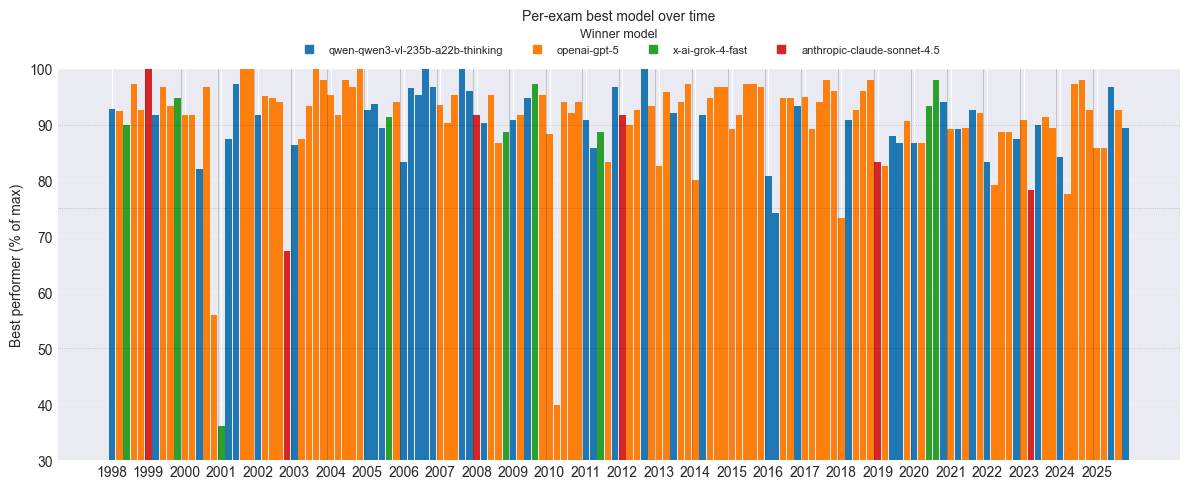

In [92]:
# Best-performer per exam timeline (color = model; height = % of max)
import numpy as np
import matplotlib.pyplot as plt

if exam_all.empty:
    print('No exam data to plot.')
else:
    # Build max score per exam (year, exam) using any run's question maxima + start capital
    exam_keys = {(int(row.year), row.exam) for row in exam_all.itertuples(index=False)}
    exam_max_scores = {}
    for info in registry.values():
        df = info['dataframe']
        for (year, group), g in df.groupby(['year', 'group'], dropna=False):
            key = (int(year), group)
            if key in exam_keys and key not in exam_max_scores:
                max_score = score_utils.start_points_for_group(group) + float(g['max_points'].sum())
                exam_max_scores[key] = max_score
        if len(exam_max_scores) == len(exam_keys):
            break

    # Compute percent-of-max for each run per exam
    ex = exam_all.copy()
    ex['year'] = ex['year'].astype(int)
    ex['max_score'] = ex.apply(lambda r: exam_max_scores.get((int(r['year']), r['exam']), np.nan), axis=1)
    ex['pct_of_max'] = ex['total_score'] / ex['max_score'] * 100.0

    metric_col = 'pct_of_max' if ex['pct_of_max'].notna().any() else 'total_score'

    # Winner rows
    ex_sorted = ex.sort_values(['year', 'exam', metric_col], ascending=[True, True, False])
    winners = ex_sorted.groupby(['year', 'exam'], as_index=False).first()

    # Grade bucket sort: by primary grade number (3-4, 5-6, 7-8, 9-10, 11-13)
    def _primary_grade(label: str) -> int:
        try:
            return int(str(label).split('-')[0])
        except Exception:
            return 0

    winners['grade_sort'] = winners['exam'].map(_primary_grade)
    winners = winners.sort_values(['year', 'grade_sort']).reset_index(drop=True)

    # Prepare plotting with built-in colormap
    models = list(winners['model'].unique())
    
    # Use tab10 for up to 10 models, tab20 for more
    cmap_name = 'tab10' if len(models) <= 10 else 'tab20'
    cmap = plt.colormaps.get_cmap(cmap_name)
    colors = {m: cmap(i % cmap.N) for i, m in enumerate(models)}
    
    # Save global color mapping so subsequent plots can reuse exact same colors
    global MODEL_COLORS, MODEL_COLORMAP_NAME, MODEL_COLOR_ORDER
    MODEL_COLORS = dict(colors)
    MODEL_COLORMAP_NAME = cmap_name
    MODEL_COLOR_ORDER = list(models)

    x = np.arange(len(winners))
    y = (
        winners[metric_col].values
        if metric_col == 'pct_of_max'
        else (winners['total_score'].values / winners['max_score'].values) * 100.0
)
    bar_colors = [colors[m] for m in winners['model']]

    # Year tick positions: first exam of each year
    group_first = winners.groupby('year', as_index=False).head(1)
    year_first_idx = group_first.index.tolist()
    year_labels = group_first['year'].astype(int).tolist()

    fig_w = max(12, min(26, 2 + 0.07 * len(winners)))
    fig, ax = plt.subplots(figsize=(fig_w, 5))
    ax.bar(x, y, color=bar_colors, width=0.9, edgecolor='none')

    finite_y = y[np.isfinite(y)]
    if finite_y.size:
        lower = max(0, np.floor((finite_y.min() - 5) / 5) * 5)
        ax.set_ylim(lower, 100)
    else:
        ax.set_ylim(0, 100)
    ax.set_ylabel('Best performer (% of max)')
    # X ticks: label by year at first exam only to reduce clutter
    ax.set_xticks(year_first_idx, labels=year_labels, rotation=0)

    # Vertical separators at year boundaries
    for idx in year_first_idx:
        if idx != 0:
            ax.axvline(idx - 0.5, color='k', linewidth=0.5, alpha=0.25)

    # Horizontal guide lines
    for yy in (50, 75, 90):
        ax.axhline(yy, color='k', linestyle=':', linewidth=0.5, alpha=0.3)

    ax.grid(axis='y', alpha=0.25)

    # Legend positioned above plot to avoid overlap
    handles = [
        plt.Line2D([0], [0], marker='s', color=c, linestyle='None', markersize=6, label=m)
        for m, c in colors.items()
    ]
    
    ax.set_title('Per-exam best model over time', pad=35, fontsize=10)
    
    legend = ax.legend(
        handles=handles,
        title='Winner model',
        ncols=min(4, len(handles)),
        loc='upper center',
        bbox_to_anchor=(0.5, 1.13),
        frameon=False,
        fontsize=8,
        title_fontsize=9,
    )

    fig.tight_layout()

    winners_timeline = winners.assign(
        pct_best=np.where(
            metric_col == 'pct_of_max',
            winners['pct_of_max'],
            (winners['total_score'] / winners['max_score']) * 100.0,
        )
)[['year', 'exam', 'model', 'pct_best', 'total_score', 'max_score']]

    plt.show()


In [93]:

if 'winners_timeline' not in globals() or winners_timeline.empty:
    print('Run the timeline cell first to compute winners_timeline.')
else:
    table = winners_timeline.copy()
    table['exam_label'] = table.apply(lambda r: f"{int(r['year'])} {r['exam']}", axis=1)
    table = table.sort_values(['pct_best', 'year'], ascending=[False, True])

    top5 = table.head(5)
    bottom5 = table.sort_values('pct_best', ascending=True).head(5)

    def _format(df, title):
        view = df[['exam_label', 'model', 'pct_best', 'total_score', 'max_score']].copy()
        view['pct_best'] = view['pct_best'].map(lambda v: f"{v:.1f}%")
        view['total_score'] = view['total_score'].map(lambda v: f"{v:.1f}")
        view['max_score'] = view['max_score'].map(lambda v: f"{v:.1f}")
        display(view.rename(columns={'exam_label': 'exam', 'pct_best': '% of max'}).style.set_caption(title))

    _format(top5, 'Top 5 exams (highest best-performer % of max)')
    _format(bottom5, 'Bottom 5 exams (lowest best-performer % of max)')



,exam,model,% of max,total_score,max_score
5,1999 3-4,anthropic-claude-sonnet-4.5,100.0%,84.0,84.0
18,2001 9-10,openai-gpt-5,100.0%,145.0,145.0
19,2001 11-13,openai-gpt-5,100.0%,150.0,150.0
28,2003 9-10,openai-gpt-5,100.0%,150.0,150.0
34,2004 11-13,openai-gpt-5,100.0%,150.0,150.0


,exam,model,% of max,total_score,max_score
15,2001 3-4,x-ai-grok-4-fast,36.1%,39.0,108.0
61,2010 5-6,openai-gpt-5,39.8%,49.0,123.0
14,2000 11-13,openai-gpt-5,56.0%,84.0,150.0
24,2002 11-13,anthropic-claude-sonnet-4.5,67.3%,101.0,150.0
100,2018 3-4,openai-gpt-5,73.3%,88.0,120.0


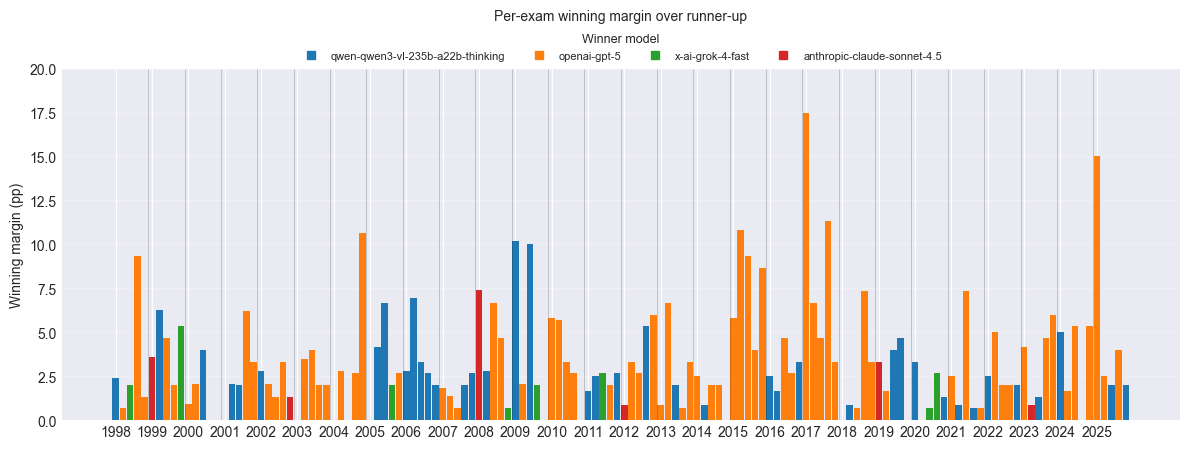

In [94]:
# Winning margin over second-best per exam (percentage points)
import numpy as np
import matplotlib.pyplot as plt

if exam_all.empty:
    print('No exam data to plot.')
else:
    exam_keys = {(int(row.year), row.exam) for row in exam_all.itertuples(index=False)}
    exam_max_scores = {}
    for info in registry.values():
        df = info['dataframe']
        for (year, group), g in df.groupby(['year', 'group'], dropna=False):
            key = (int(year), group)
            if key in exam_keys and key not in exam_max_scores:
                exam_max_scores[key] = score_utils.start_points_for_group(group) + float(g['max_points'].sum())
        if len(exam_max_scores) == len(exam_keys):
            break

    ex = exam_all.copy()
    ex['year'] = ex['year'].astype(int)
    ex['max_score'] = ex.apply(lambda r: exam_max_scores.get((int(r['year']), r['exam']), np.nan), axis=1)
    ex['pct_of_max'] = ex['total_score'] / ex['max_score'] * 100.0

    metric_col = 'pct_of_max' if ex['pct_of_max'].notna().any() else 'total_score'

    def _primary_grade(label: str) -> int:
        try:
            return int(str(label).split('-')[0])
        except Exception:
            return 0

    rows = []
    for (year, exam), group in ex.sort_values(['year', 'exam', metric_col], ascending=[True, True, False]).groupby(['year', 'exam']):
        group = group.reset_index(drop=True)
        top = group.iloc[0]
        runner = group.iloc[1] if len(group) > 1 else None

        best_pct = (
            top['pct_of_max']
            if metric_col == 'pct_of_max'
            else (top['total_score'] / top['max_score']) * 100.0
        )
        if runner is not None:
            runner_pct = (
                runner['pct_of_max']
                if metric_col == 'pct_of_max'
                else (runner['total_score'] / runner['max_score']) * 100.0
            )
            margin = best_pct - runner_pct
        else:
            runner_pct = np.nan
            margin = np.nan

        rows.append({
            'year': int(year),
            'exam': exam,
            'grade_sort': _primary_grade(exam),
            'winner_model': top['model'],
            'runner_model': runner['model'] if runner is not None else None,
            'winner_pct': best_pct,
            'runner_pct': runner_pct,
            'margin_pct': margin,
        })

    margin_df = pd.DataFrame(rows)
    margin_df = margin_df.sort_values(['year', 'grade_sort']).reset_index(drop=True)

    if margin_df['margin_pct'].notna().any():
        models = list(margin_df['winner_model'].dropna().unique())
        
        # Use tab10 for up to 10 models, tab20 for more
        cmap_name = 'tab10' if len(models) <= 10 else 'tab20'
        cmap = plt.colormaps.get_cmap(cmap_name)
        colors = {m: cmap(i % cmap.N) for i, m in enumerate(models)}

        x = np.arange(len(margin_df))
        y = margin_df['margin_pct'].fillna(0).values
        bar_colors = [colors.get(m, '#999999') for m in margin_df['winner_model']]

        group_first = margin_df.groupby('year', as_index=False).head(1)
        year_first_idx = group_first.index.tolist()
        year_labels = group_first['year'].astype(int).tolist()

        fig_w = max(12, min(26, 2 + 0.07 * len(margin_df)))
        fig, ax = plt.subplots(figsize=(fig_w, 4.6))
        ax.bar(x, y, color=bar_colors, width=0.9, edgecolor='none')

        finite_y = y[np.isfinite(y)]
        upper = max(5, np.ceil((np.nanmax(finite_y) + 1) / 5) * 5) if finite_y.size else 5
        ax.set_ylim(0, upper)
        ax.set_ylabel('Winning margin (pp)')

        ax.set_xticks(year_first_idx, labels=year_labels, rotation=0)
        for idx in year_first_idx:
            if idx != 0:
                ax.axvline(idx - 0.5, color='k', linewidth=0.5, alpha=0.25)

        ax.axhline(0, color='k', linewidth=0.6, alpha=0.4)
        ax.grid(axis='y', alpha=0.25)

        handles = [
            plt.Line2D([0], [0], marker='s', color=colors[m], linestyle='None', markersize=6, label=m)
            for m in models
        ]
        
        ax.set_title('Per-exam winning margin over runner-up', pad=35, fontsize=10)
        
        ax.legend(
            handles=handles,
            title='Winner model',
            ncols=min(4, len(handles)),
            loc='upper center',
            bbox_to_anchor=(0.5, 1.13),
            frameon=False,
            fontsize=8,
            title_fontsize=9,
        )
        fig.tight_layout()
        plt.show()
    else:
        print('Insufficient data to compute margins (need at least two runs per exam).')

In [95]:
if grade_all.empty:
    print("No grade-level breakdown available.")
else:
    grade_all_sorted = grade_all.copy()
    grade_all_sorted['grade_sort'] = grade_all_sorted['grade'].apply(_grade_sort_key)
    grade_all_sorted = grade_all_sorted.sort_values(['grade_sort', 'grade', 'model'])

    recall_pivot = grade_all_sorted.pivot_table(index='grade', columns='model', values='recall')
    recall_pivot = recall_pivot.loc[[g for g in recall_pivot.index if g == g]]
    recall_pivot = recall_pivot.mul(100)
    display(recall_pivot.style.format('{:.1f}').set_caption('Recall by grade (correct / total) [%]'))

    attempt_pivot = grade_all_sorted.pivot_table(index='grade', columns='model', values='attempt_rate')
    attempt_pivot = attempt_pivot.mul(100)
    display(attempt_pivot.style.format('{:.1f}').set_caption('Attempt rate by grade [%]'))

    if 'multimodal_share_pct' in grade_all_sorted.columns:
        mm_pivot = grade_all_sorted.pivot_table(index='grade', columns='model', values='multimodal_share_pct')
        display(mm_pivot.style.format('{:.1f}').set_caption('Multimodal share of questions per grade [%]'))

model,anthropic-claude-sonnet-4.5,openai-gpt-5,qwen-qwen3-vl-235b-a22b-thinking,x-ai-grok-4-fast
grade,,,,
11-13,77.6,88.7,86.7,81.5
3-4,74.3,79.5,78.3,65.0
5-6,72.5,83.0,80.8,69.3
7-8,77.1,89.3,87.9,81.0
9-10,78.2,92.3,88.9,84.6


model,anthropic-claude-sonnet-4.5,openai-gpt-5,qwen-qwen3-vl-235b-a22b-thinking,x-ai-grok-4-fast
grade,,,,
11-13,99.2,98.1,99.6,93.2
3-4,99.7,96.1,100.0,80.3
5-6,99.2,96.2,100.0,83.4
7-8,98.8,96.5,100.0,89.2
9-10,99.4,97.5,99.9,92.1


model,anthropic-claude-sonnet-4.5,openai-gpt-5,qwen-qwen3-vl-235b-a22b-thinking,x-ai-grok-4-fast
grade,,,,
11-13,37.7,37.7,37.7,37.7
3-4,55.4,55.4,55.4,55.4
5-6,52.5,52.5,52.5,52.5
7-8,43.8,43.8,43.8,43.8
9-10,38.9,38.9,38.9,38.9


In [96]:

if summary_df.empty:
    print("No runs loaded. Adjust selections and rerun earlier cells.")
elif grade_all.empty and modality_all.empty:
    print("No grade or modality breakdowns available for comparison.")
else:
    outputs = []

    if not grade_all.empty:
        grade_view = grade_all.copy()
        grade_view = grade_view[grade_view['recall'].notna()]
        if not grade_view.empty:
            grade_view['grade_sort'] = grade_view['grade'].apply(_grade_sort_key)
            grade_view = grade_view.sort_values(['grade_sort', 'grade', 'recall'], ascending=[True, True, False])

            winner_rows = []
            for grade, group in grade_view.groupby('grade', dropna=False):
                group = group.sort_values('recall', ascending=False)
                top = group.iloc[0]
                margin = (top['recall'] - group.iloc[1]['recall']) if len(group) > 1 else float('nan')
                winner_rows.append({
                    'grade': grade,
                    'best_model': top['model'],
                    'recall_pct': top['recall'] * 100,
                    'margin_pct': margin * 100 if margin == margin else float('nan'),
                    'attempt_rate_pct': top['attempt_rate'] * 100 if top['attempt_rate'] == top['attempt_rate'] else float('nan'),
                    'decline_rate_pct': top['decline_rate'] * 100 if top['decline_rate'] == top['decline_rate'] else float('nan'),
                })
            grade_winners = pd.DataFrame(winner_rows).sort_values('grade', key=lambda s: s.map(_grade_sort_key))
            display(
                grade_winners
                .style
                .format({
                    'recall_pct': '{:.1f}%',
                    'margin_pct': '{:.1f} pp',
                    'attempt_rate_pct': '{:.1f}%',
                    'decline_rate_pct': '{:.1f}%'
                })
                .set_caption('Top model per grade (recall-based)')
            )

    if not modality_all.empty:
        mod_view = modality_all.copy()
        mod_view = mod_view[mod_view['recall'].notna()]
        if not mod_view.empty:
            mod_view = mod_view.sort_values(['modality', 'recall'], ascending=[True, False])
            mod_rows = []
            for modality, group in mod_view.groupby('modality', dropna=False):
                group = group.reset_index(drop=True)
                top = group.iloc[0]
                margin = (top['recall'] - group.iloc[1]['recall']) if len(group) > 1 else float('nan')
                mod_rows.append({
                    'modality': modality,
                    'best_model': top['model'],
                    'recall_pct': top['recall'] * 100,
                    'margin_pct': margin * 100 if margin == margin else float('nan'),
                    'attempt_rate_pct': top['attempt_rate'] * 100 if top['attempt_rate'] == top['attempt_rate'] else float('nan'),
                })
            modality_winners = pd.DataFrame(mod_rows)
            display(
                modality_winners
                .style
                .format({
                    'recall_pct': '{:.1f}%',
                    'margin_pct': '{:.1f} pp',
                    'attempt_rate_pct': '{:.1f}%'
                })
                .set_caption('Top model per modality (recall-based)')
            )

    year_rows = []
    for run_id, info in registry.items():
        df = info['dataframe']
        model_label = info['summary']['model']
        for year, group in df.groupby('year', dropna=False):
            metrics = compute_slice_metrics(group)
            if metrics['recall'] == metrics['recall']:
                year_rows.append({
                    'year': year,
                    'model': model_label,
                    'recall': metrics['recall'],
                    'attempt_rate': metrics['attempt_rate'],
                })
    if year_rows:
        year_df = pd.DataFrame(year_rows)
        year_df = year_df.sort_values(['year', 'recall'], ascending=[True, False])
        year_winners = []
        for year, group in year_df.groupby('year', dropna=False):
            group = group.reset_index(drop=True)
            top = group.iloc[0]
            margin = (top['recall'] - group.iloc[1]['recall']) if len(group) > 1 else float('nan')
            year_winners.append({
                'year': year,
                'best_model': top['model'],
                'recall_pct': top['recall'] * 100,
                'margin_pct': margin * 100 if margin == margin else float('nan'),
                'attempt_rate_pct': top['attempt_rate'] * 100 if top['attempt_rate'] == top['attempt_rate'] else float('nan'),
            })
        year_winners_df = pd.DataFrame(year_winners).sort_values('year')
        display(
            year_winners_df
            .style
            .format({
                'recall_pct': '{:.1f}%',
                'margin_pct': '{:.1f} pp',
                'attempt_rate_pct': '{:.1f}%'
            })
            .set_caption('Top model per year (recall-based)')
        )
    else:
        print("No year-level breakdown available (missing year data).")



,grade,best_model,recall_pct,margin_pct,attempt_rate_pct,decline_rate_pct
1,3-4,openai-gpt-5,79.5%,1.1 pp,96.1%,3.9%
2,5-6,openai-gpt-5,83.0%,2.1 pp,96.2%,3.8%
3,7-8,openai-gpt-5,89.3%,1.4 pp,96.5%,3.5%
4,9-10,openai-gpt-5,92.3%,3.3 pp,97.5%,2.5%
0,11-13,openai-gpt-5,88.7%,2.0 pp,98.1%,1.9%


,modality,best_model,recall_pct,margin_pct,attempt_rate_pct
0,Multimodal,openai-gpt-5,74.6%,4.1 pp,93.8%
1,Text-only,openai-gpt-5,97.1%,0.4 pp,99.5%


,year,best_model,recall_pct,margin_pct,attempt_rate_pct
0,1998,openai-gpt-5,88.9%,5.2 pp,97.8%
1,1999,openai-gpt-5,90.4%,1.5 pp,98.5%
2,2000,openai-gpt-5,78.7%,0.0 pp,97.2%
3,2001,openai-gpt-5,82.9%,2.1 pp,97.9%
4,2002,openai-gpt-5,85.1%,1.4 pp,97.2%
5,2003,openai-gpt-5,90.7%,2.9 pp,99.3%
6,2004,openai-gpt-5,95.7%,4.3 pp,97.9%
7,2005,qwen-qwen3-vl-235b-a22b-thinking,88.7%,3.5 pp,100.0%
8,2006,qwen-qwen3-vl-235b-a22b-thinking,94.3%,4.3 pp,100.0%
9,2007,openai-gpt-5,92.2%,0.7 pp,97.9%


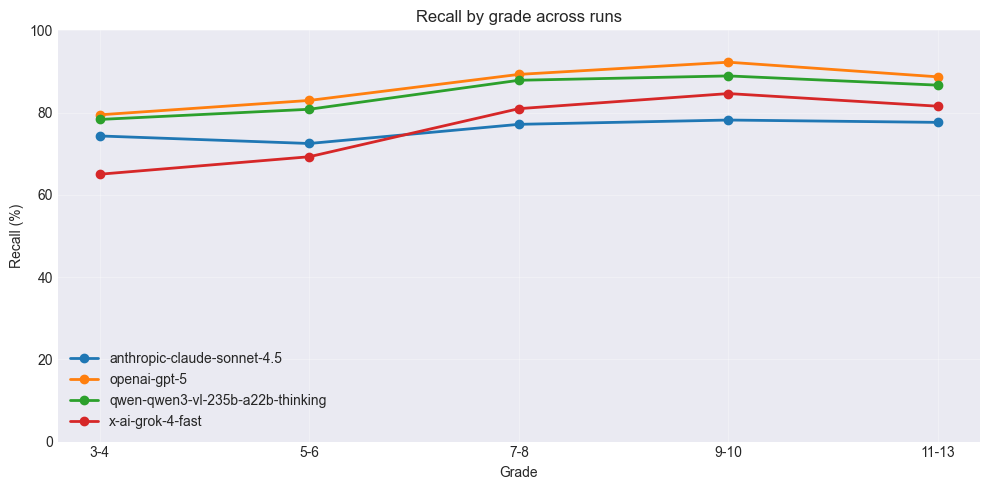

In [97]:
if grade_all.empty:
    print("Skip grade visualizations: no data.")
else:
    grade_all_sorted = grade_all.copy()
    grade_all_sorted['grade_sort'] = grade_all_sorted['grade'].apply(_grade_sort_key)
    grade_all_sorted = grade_all_sorted.sort_values(['grade_sort', 'grade'])
    grade_order = [g for g in grade_all_sorted['grade'].unique() if g == g]
    x = np.arange(len(grade_order))

    fig, ax = plt.subplots(figsize=(10, 5))
    for model, subset in grade_all_sorted.groupby('model'):
        subset = subset.set_index('grade').reindex(grade_order)
        ax.plot(x, subset['recall'] * 100, marker='o', linewidth=2, label=model)
    ax.set_xticks(x, grade_order)
    ax.set_ylabel('Recall (%)')
    ax.set_xlabel('Grade')
    ax.set_title('Recall by grade across runs')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

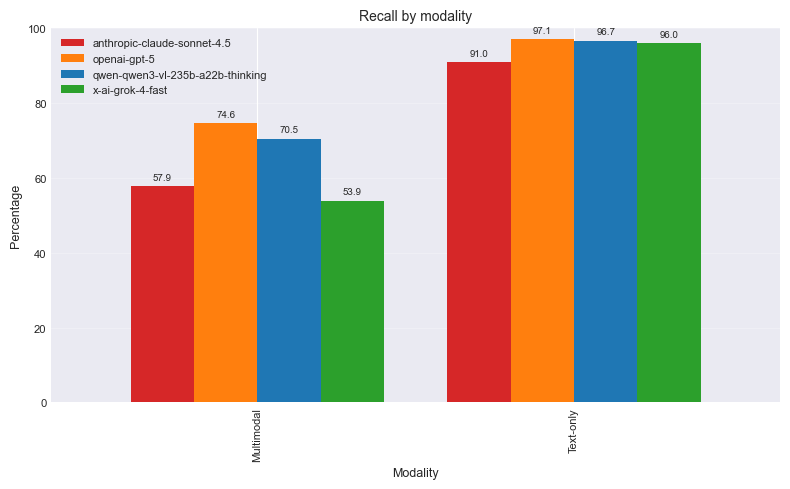

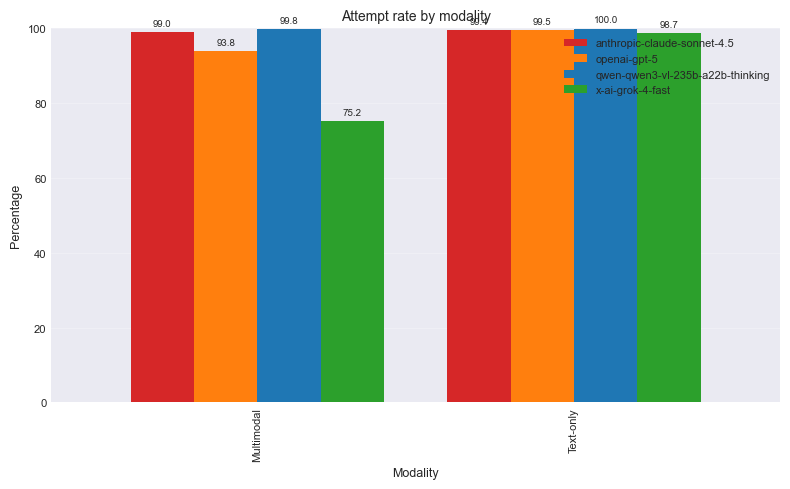

In [98]:
if modality_all.empty:
    print("No modality breakdown available.")
else:
    modality_recall = modality_all.pivot_table(index='modality', columns='model', values='recall').mul(100)
    modality_attempt = modality_all.pivot_table(index='modality', columns='model', values='attempt_rate').mul(100)

    # Use exact same color mapping as timeline plot
    if 'MODEL_COLORS' in globals() and MODEL_COLORS:
        # Use saved colors from timeline plot
        color_map = MODEL_COLORS
    else:
        # Fallback: create color map (should match timeline logic)
        models = list(modality_all['model'].unique())
        cmap_name = 'tab10' if len(models) <= 10 else 'tab20'
        cmap = plt.colormaps.get_cmap(cmap_name)
        color_map = {m: cmap(i % cmap.N) for i, m in enumerate(models)}
    
    # Create color list matching the order of columns in pivot tables
    color_list = [color_map.get(m, '#999999') for m in modality_recall.columns]

    # Plot recall
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    bars1 = modality_recall.plot(kind='bar', ax=ax1, color=color_list, width=0.8, edgecolor='none')
    ax1.set_title('Recall by modality', fontsize=10)
    ax1.set_ylabel('Percentage', fontsize=9)
    ax1.set_xlabel('Modality', fontsize=9)
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.25)
    ax1.tick_params(axis='both', labelsize=8)
    ax1.legend(loc='best', fontsize=8, frameon=False)
    
    # Add value labels on bars
    for container in bars1.containers:
        ax1.bar_label(container, fmt='%.1f', fontsize=7, padding=3)
    
    plt.tight_layout()
    plt.show()

    # Plot attempt rate
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    bars2 = modality_attempt.plot(kind='bar', ax=ax2, color=color_list, width=0.8, edgecolor='none')
    ax2.set_title('Attempt rate by modality', fontsize=10)
    ax2.set_ylabel('Percentage', fontsize=9)
    ax2.set_xlabel('Modality', fontsize=9)
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.25)
    ax2.tick_params(axis='both', labelsize=8)
    ax2.legend(loc='best', fontsize=8, frameon=False)
    
    # Add value labels on bars
    for container in bars2.containers:
        ax2.bar_label(container, fmt='%.1f', fontsize=7, padding=3)
    
    plt.tight_layout()
    plt.show()

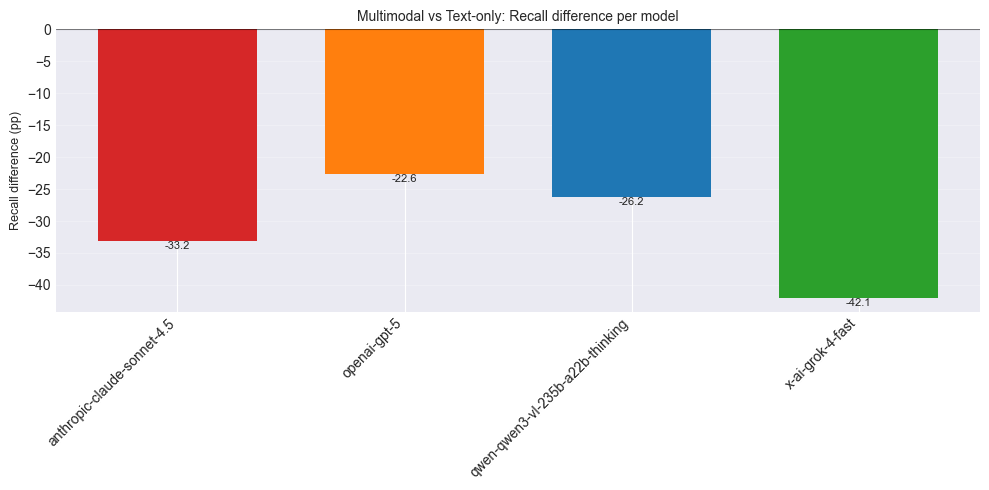

,model,multimodal_recall,text_only_recall,delta_pp
0,anthropic-claude-sonnet-4.5,57.9%,91.0%,-33.2 pp
1,openai-gpt-5,74.6%,97.1%,-22.6 pp
2,qwen-qwen3-vl-235b-a22b-thinking,70.5%,96.7%,-26.2 pp
3,x-ai-grok-4-fast,53.9%,96.0%,-42.1 pp


In [99]:
if modality_all.empty:
    print("No modality breakdown available for delta calculation.")
else:
    # Calculate delta: multimodal recall - text-only recall for each model
    delta_rows = []
    for model, model_data in modality_all.groupby('model'):
        model_data = model_data.set_index('modality')
        
        if 'Multimodal' in model_data.index and 'Text-only' in model_data.index:
            mm_recall = model_data.loc['Multimodal', 'recall']
            text_recall = model_data.loc['Text-only', 'recall']
            
            if pd.notna(mm_recall) and pd.notna(text_recall):
                delta = (mm_recall - text_recall) * 100  # Convert to percentage points
                delta_rows.append({
                    'model': model,
                    'multimodal_recall': mm_recall * 100,
                    'text_only_recall': text_recall * 100,
                    'delta_pp': delta
                })
    
    if not delta_rows:
        print("Insufficient modality data to compute deltas.")
    else:
        delta_df = pd.DataFrame(delta_rows)
        
        # Use exact same color mapping as timeline plot
        if 'MODEL_COLORS' in globals() and MODEL_COLORS:
            color_map = MODEL_COLORS
        else:
            models = list(delta_df['model'].unique())
            cmap_name = 'tab10' if len(models) <= 10 else 'tab20'
            cmap = plt.colormaps.get_cmap(cmap_name)
            color_map = {m: cmap(i % cmap.N) for i, m in enumerate(models)}
        
        # Create color list for bars
        color_list = [color_map.get(m, '#999999') for m in delta_df['model']]
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(delta_df))
        bars = ax.bar(x, delta_df['delta_pp'], color=color_list, width=0.7, edgecolor='none')
        
        # Styling
        ax.set_xticks(x)
        ax.set_xticklabels(delta_df['model'], rotation=45, ha='right')
        ax.set_ylabel('Recall difference (pp)', fontsize=9)
        ax.set_title('Multimodal vs Text-only: Recall difference per model', fontsize=10)
        ax.axhline(0, color='k', linewidth=0.8, alpha=0.5, linestyle='-')
        ax.grid(axis='y', alpha=0.25)
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, delta_df['delta_pp'])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:+.1f}',
                   ha='center', va='bottom' if height >= 0 else 'top',
                   fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Display summary table
        display(
            delta_df
            .style
            .format({
                'multimodal_recall': '{:.1f}%',
                'text_only_recall': '{:.1f}%',
                'delta_pp': '{:+.1f} pp'
            })
            .set_caption('Recall difference: Multimodal - Text-only (percentage points)')
        )

,points_per_1k_tokens,correct_per_1k_tokens,net_points_per_1k_tokens,tokens_per_point
model,,,,
openai-gpt-5,1.29,0.32,1.26,773
qwen-qwen3-vl-235b-a22b-thinking,1.09,0.27,1.04,919
x-ai-grok-4-fast,1.16,0.29,1.12,860
anthropic-claude-sonnet-4.5,4.45,1.12,4.10,224


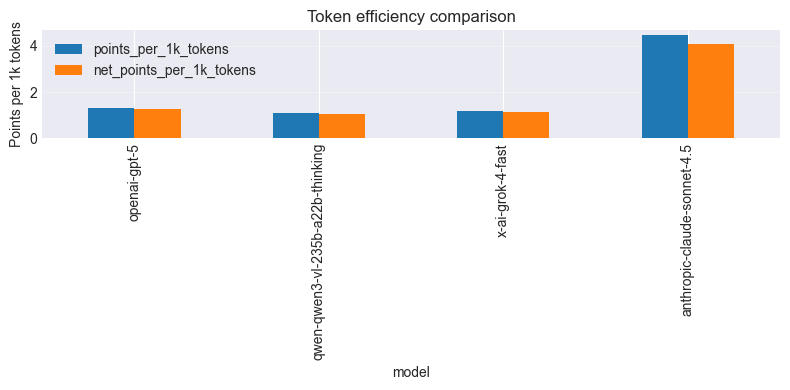

In [100]:
if summary_df.empty or summary_df[['points_per_1k_tokens', 'correct_per_1k_tokens', 'net_points_per_1k_tokens', 'tokens_per_point']].isna().all().all():
    print("No token-related metrics available across the selected runs.")
else:
    token_view = summary_df.set_index('model')[['points_per_1k_tokens', 'correct_per_1k_tokens', 'net_points_per_1k_tokens', 'tokens_per_point']]
    token_view = token_view.replace([np.inf, -np.inf], np.nan).dropna(how='all')
    if token_view.empty:
        print("Token columns exist but contain no finite values.")
    else:
        display(token_view.style.format({
            'points_per_1k_tokens': '{:.2f}',
            'correct_per_1k_tokens': '{:.2f}',
            'net_points_per_1k_tokens': '{:.2f}',
            'tokens_per_point': '{:.0f}'
        }).set_caption('Token efficiency metrics'))

        fig, ax = plt.subplots(figsize=(8, 4))
        (token_view[['points_per_1k_tokens', 'net_points_per_1k_tokens']]
            .plot(kind='bar', ax=ax))
        ax.set_ylabel('Points per 1k tokens')
        ax.set_title('Token efficiency comparison')
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

,decline_rate_pct
model,
x-ai-grok-4-fast,11.86%
openai-gpt-5,3.04%
anthropic-claude-sonnet-4.5,0.77%
qwen-qwen3-vl-235b-a22b-thinking,0.00%


model,anthropic-claude-sonnet-4.5,openai-gpt-5,qwen-qwen3-vl-235b-a22b-thinking,x-ai-grok-4-fast
modality,,,,
Multimodal,1.03%,6.18%,0.00%,24.84%
Text-only,0.56%,0.47%,0.00%,1.26%


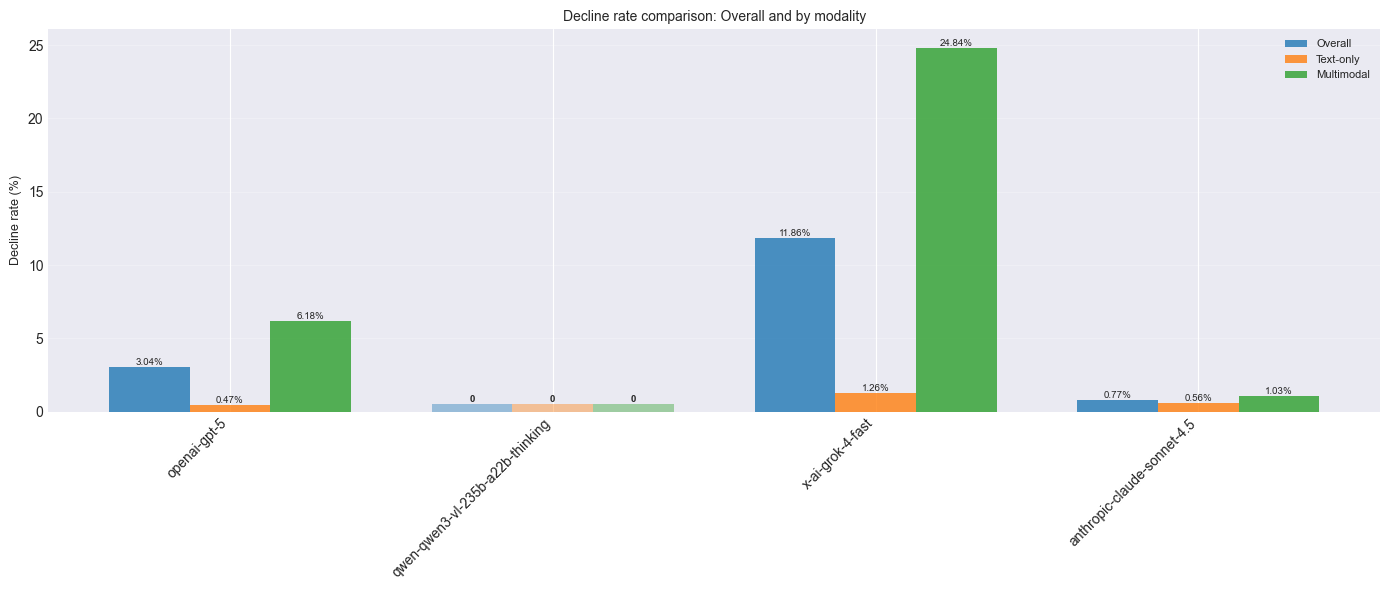

In [101]:
# Decline Rate Analysis

if summary_df.empty:
    print("No runs loaded. Adjust run_ids and re-execute.")
else:
    # Overall decline rates
    overall_decline = summary_df[['model', 'decline_rate']].copy()
    overall_decline['decline_rate_pct'] = overall_decline['decline_rate'] * 100
    
    # Display overall decline rates table
    display(
        overall_decline.set_index('model')[['decline_rate_pct']]
        .sort_values('decline_rate_pct', ascending=False)
        .style
        .format({'decline_rate_pct': '{:.2f}%'})
        .set_caption('Overall decline rate per model')
    )
    
    # Per-modality decline rates
    if not modality_all.empty:
        modality_decline = modality_all.pivot_table(
            index='modality', 
            columns='model', 
            values='decline_rate'
        ).mul(100)
        
        display(
            modality_decline
            .style
            .format('{:.2f}%')
            .set_caption('Decline rate by modality')
        )
        
        # Single combined visualization: Overall + per-modality decline rates
        fig, ax = plt.subplots(figsize=(14, 6))
        
        models_list = list(overall_decline['model'])
        x_positions = np.arange(len(models_list))
        width = 0.25
        min_bar_height = 0.5
        
        modalities = ['Overall', 'Text-only', 'Multimodal']
        cmap = plt.colormaps.get_cmap('tab10')
        modality_colors = {mod: cmap(i) for i, mod in enumerate(modalities)}
        
        for i, modality in enumerate(modalities):
            if modality == 'Overall':
                values = overall_decline['decline_rate_pct'].values
            elif modality == 'Text-only':
                values = modality_decline.loc['Text-only', models_list].values if 'Text-only' in modality_decline.index else np.zeros(len(models_list))
            else:
                values = modality_decline.loc['Multimodal', models_list].values if 'Multimodal' in modality_decline.index else np.zeros(len(models_list))
            
            offset = (i - 1) * width
            display_values = np.where(values == 0, min_bar_height, values)
            bars = ax.bar(x_positions + offset, display_values, width, label=modality, 
                         color=modality_colors[modality], edgecolor='none', alpha=0.8)
            
            for j, (bar, actual_val) in enumerate(zip(bars, values)):
                if actual_val == 0:
                    bar.set_hatch('///')
                    bar.set_alpha(0.4)
                    ax.text(bar.get_x() + bar.get_width()/2., min_bar_height,
                           '0',
                           ha='center', va='bottom',
                           fontsize=7, fontweight='bold')
                else:
                    ax.text(bar.get_x() + bar.get_width()/2., actual_val,
                           f'{actual_val:.2f}%',
                           ha='center', va='bottom',
                           fontsize=7)
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(models_list, rotation=45, ha='right')
        ax.set_ylabel('Decline rate (%)', fontsize=9)
        ax.set_title('Decline rate comparison: Overall and by modality', fontsize=10)
        ax.legend(loc='best', fontsize=8, frameon=False)
        ax.grid(axis='y', alpha=0.25)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No modality breakdown available.")
